## Data extraction

First of all, we have to collect all the .wav files into a python data structure. We also have to label the data for the further training and testing. 

In [1]:
import os
import numpy as np
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from matplotlib import pyplot as pl

In [2]:
# Constants
PATH = './vowels'
EXTENSION = '.wav'
N_FEATURES = 13

In [3]:
vowels = os.listdir(PATH)
# Every row of the dataset represents the .wav file
# The first two columns are the sample rate and the data read from the .wav file
# The 3d column is the label of the file
# There exists 6 labels:
labels = {0:'Natural Adult Male', 1:'Natural Adult Female', 2: 'Natural Kid',
         3:'Synthesized Adult Male', 4:'Synthesized Adult Female', 5:'Synthesized Kid'}
dataset = []
features = []
for v in vowels:
    filename, file_extension = os.path.splitext(v)
    if(file_extension == EXTENSION):
        if(v.startswith('nam')):
            class_num = 0
        elif(v.startswith('naf')):
            class_num = 1
        elif(v.startswith('nk')):
            class_num = 2
        elif(v.startswith('sam')):
            class_num = 3
        elif(v.startswith('saf')):
            class_num = 4
        elif(v.startswith('sk')):
            class_num = 5
        sample_rate, X = wav.read(os.path.join(PATH, v))
        dataset.append([sample_rate, X, class_num])
        ceps = mfcc(X, samplerate=sample_rate, nfft=1024)
        features.append([ceps, class_num])
len(dataset)

360

## Man vs Woman

Now we're only interested in audios containing men and women natural voices. First of all, let's extract them from the dataset.

In [4]:
m_features = [] # array containing all features of the men's (natural) voices
f_features = [] # array containing all features of the women's (natural) voices
for f in features:
    if(f[1] == 0): 
        m_features.append(f[0])
    elif(f[1] == 1):
        f_features.append(f[0]) 
m_features = np.array(m_features)
f_features = np.array(f_features)
print(m_features.shape, f_features.shape)
print(m_features[0].shape)
print(m_features[1].shape)
print(f_features[0].shape)

(36,) (36,)
(17, 13)
(23, 13)
(24, 13)


### Feature extraction

As we can see, we've got 36 collections of features for men and women voices. Every audio is split into fragments. For each fragment, the values representing 13 features are calculated.  

In [5]:
def align_by_feature(features):
    '''
    This funciton aligns all the values of the feature of all fragments
    '''
    aligned_features = []
    for i in np.arange(13):
        aligned_features.append([])
    for fragments in features: # loop over every audio 
        for features in fragments:
            for i,feature in enumerate(features):
                aligned_features[i].append(feature)
    return aligned_features

In [6]:
men_aligned = align_by_feature(m_features)
women_aligned = align_by_feature(f_features)
print(len(men_aligned)) 
print(len(men_aligned[0]))
print(len(women_aligned))
print(len(women_aligned[0]))
print(len(men_aligned[1]))
print(len(women_aligned[1]))

13
753
13
919
753
919


In [7]:
def avg_per_audio(features):
    '''
    This function calculates the average feature value for every audio.
    
    input: 
    features: contains N (number of audios) 2d fragments
    fragments: list of arrays, every array contains 13 features
    
    output:
    Nx13 numpy array
    lines: audio index
    column: feature index
    '''
    avg_features = np.zeros((features.shape[0], N_FEATURES))
    for i,audio in enumerate(features):
        sum_per_feature = np.zeros(N_FEATURES)
        for fragment in audio:
            for j, feature in enumerate(fragment):
                sum_per_feature[j] += feature
            avg_features[i, :] = sum_per_feature/float(len(audio))
    return avg_features
men_avg = avg_per_audio(m_features)
women_avg = avg_per_audio(f_features)
print(men_avg.shape)
print(women_avg.shape)

(36, 13)
(36, 13)


Since we we don't want our model to become too complex, we should first select the most convinitent features for the model. Thus, for every feature, we will compare the men and women samples.

### Plotting all of the features of all fragments (aligned)

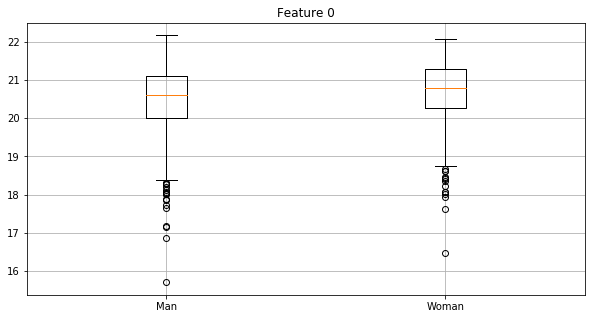

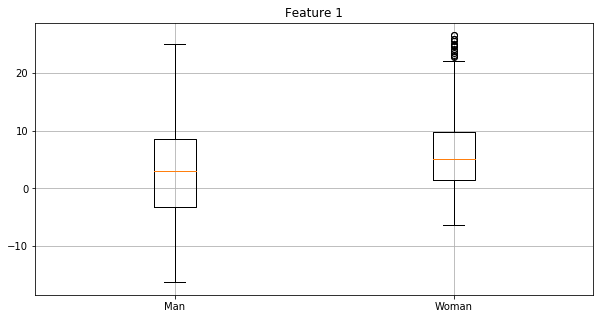

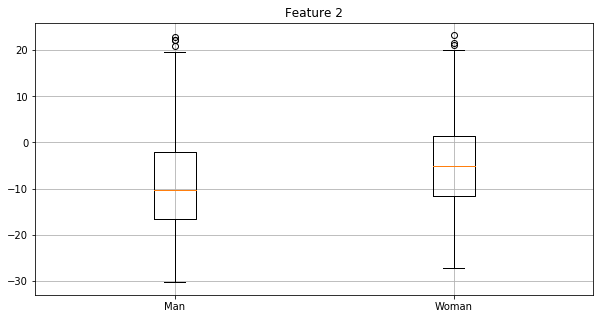

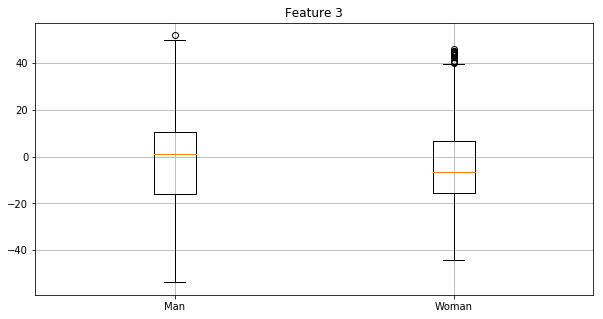

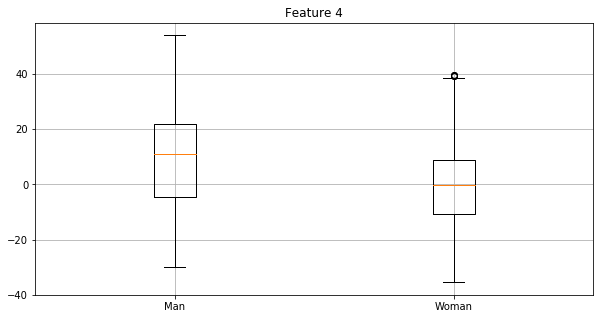

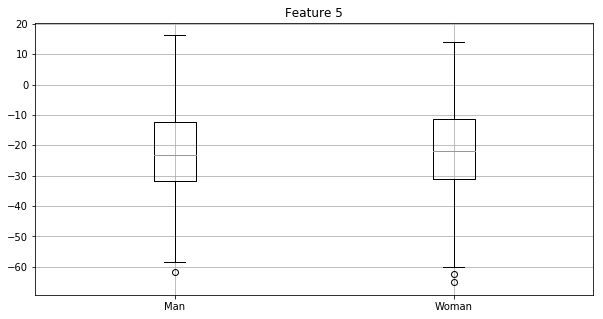

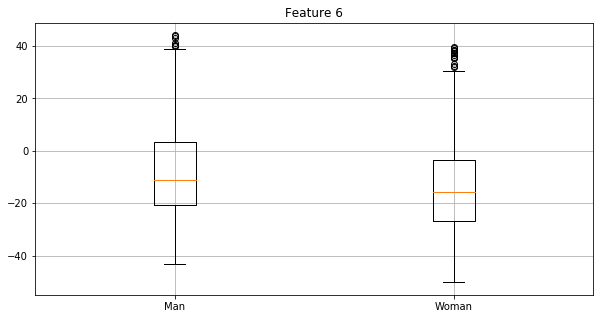

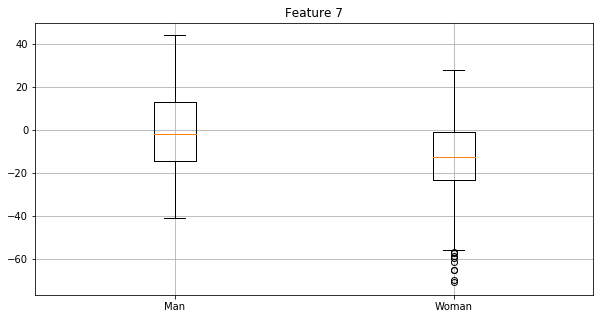

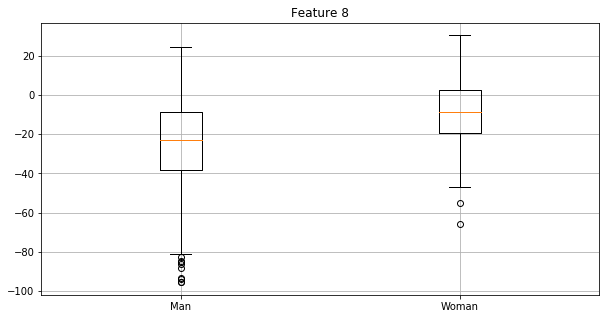

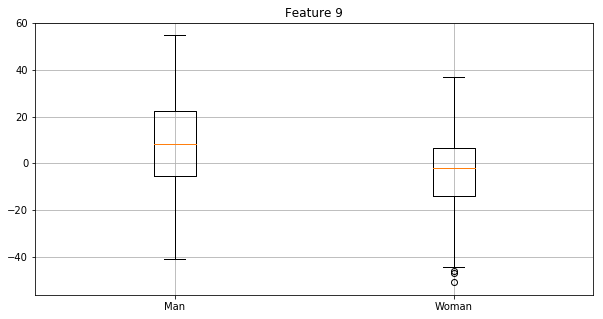

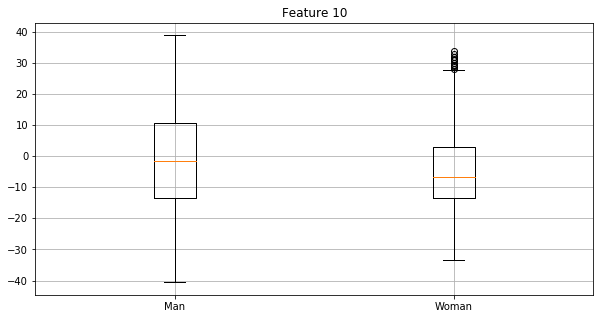

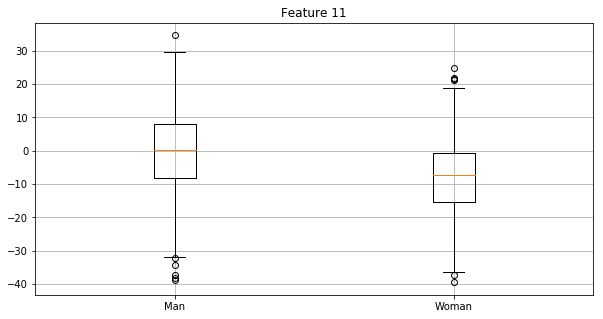

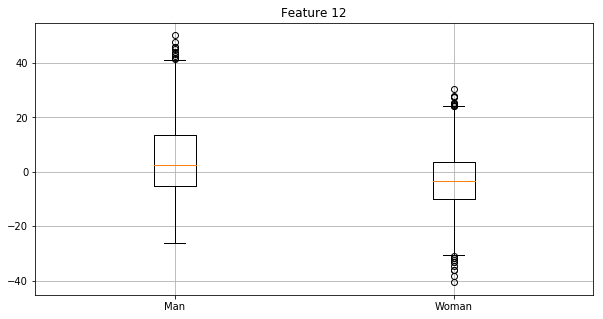

In [8]:
def boxplot_feature(m_features, f_features, k):
    pl.figure(figsize=(10,5))
    feature = np.array([m_features[k], f_features[k]])
    pl.boxplot(feature)
    pl.title('Feature '+ str(k))
    pl.xticks([1, 2], ['Man', 'Woman'])
    pl.grid()

for f in np.arange(13):
    boxplot_feature(men_aligned, women_aligned, f)


### Plotting the features, average per audio

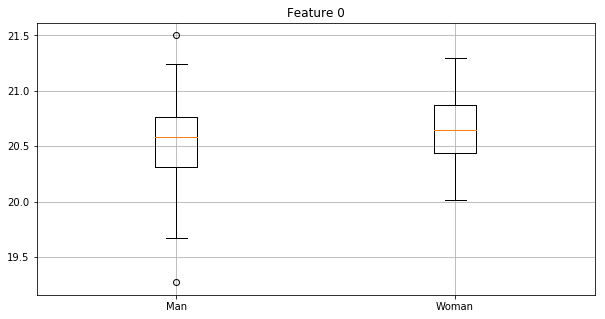

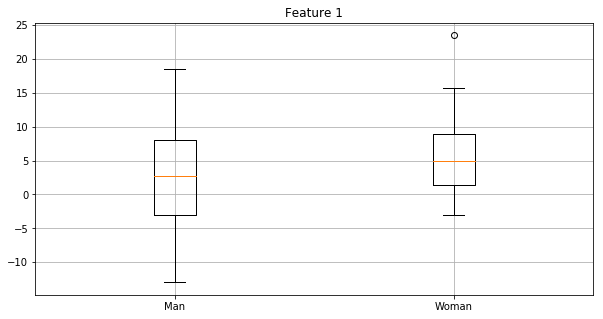

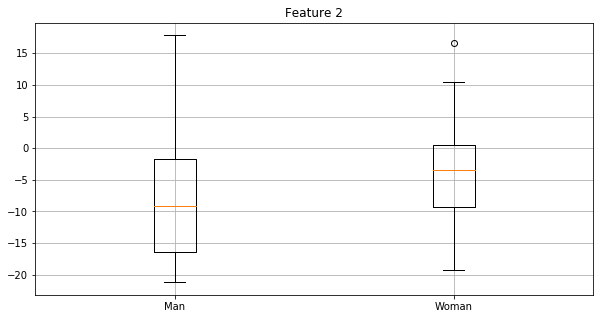

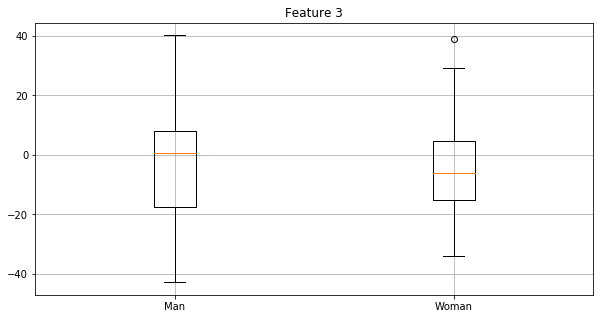

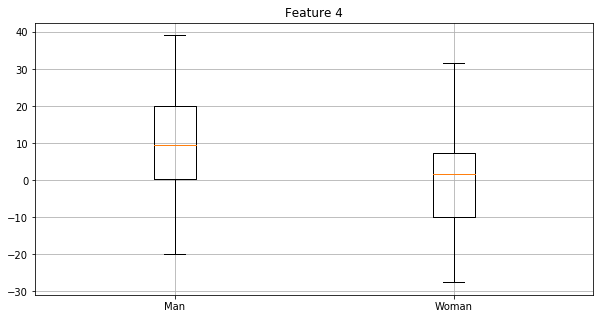

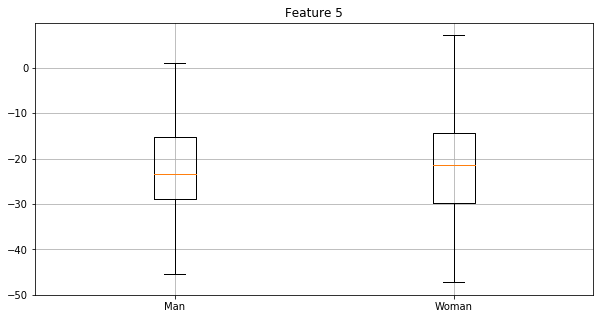

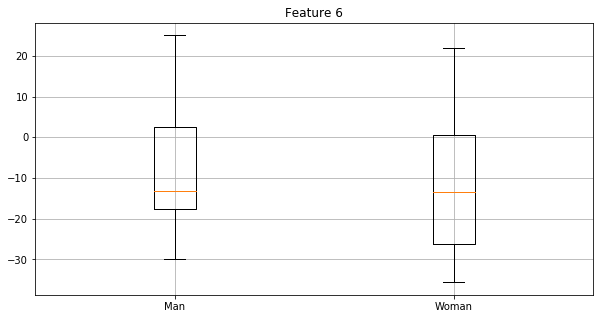

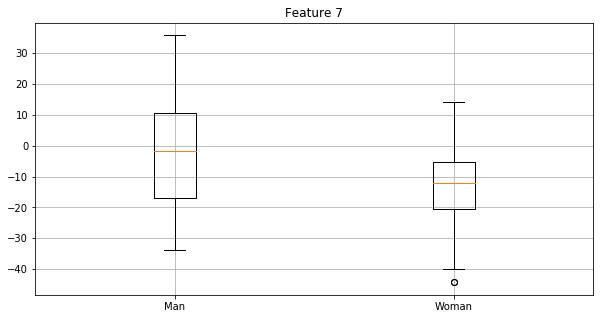

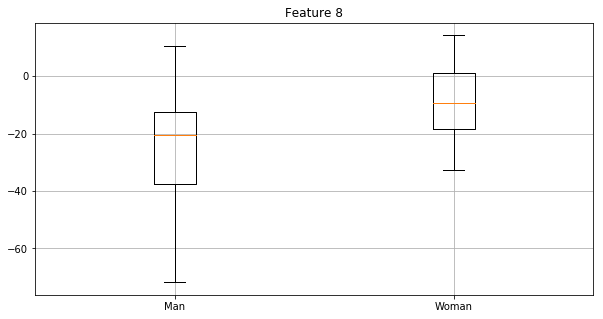

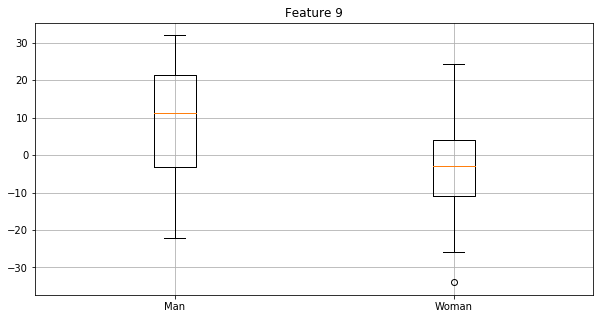

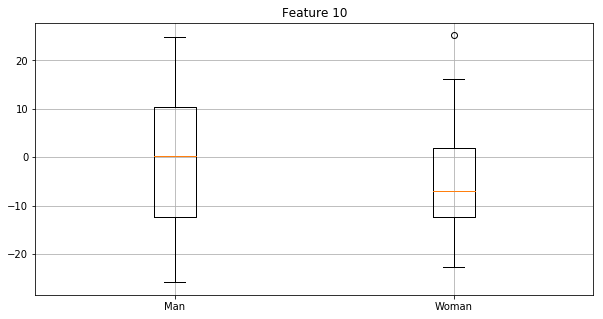

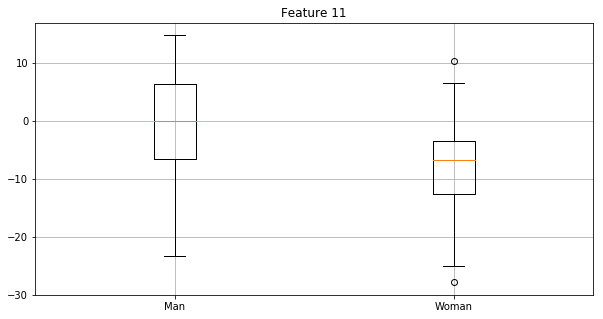

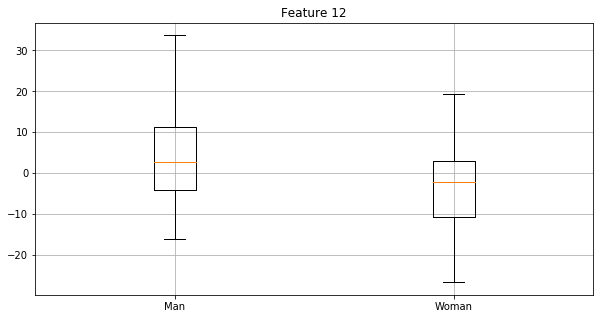

In [9]:
for f in np.arange(N_FEATURES):
    pl.figure(figsize=(10,5))
    pl.boxplot([men_avg.T[f], women_avg.T[f]])
    pl.title('Feature '+ str(f))
    pl.xticks([1, 2], ['Man', 'Woman'])
    pl.grid()

Features 2, 3, 4, 8, 9 look the most distinguishable between men and women.  
Now we will extract the features we're interested in.

In [10]:
# note: features are indexed from 0 to 12
selected_features = [2, 3, 4, 8, 9]

In [11]:
def create_dataset(m_features, f_features, feature_indexes):
    extracted = np.zeros((len(m_features[0]) + len(f_features[0]), len(feature_indexes)+1))
    for i, fi in enumerate(feature_indexes):
        extracted[:, i] = np.concatenate((m_features[fi], f_features[fi]))
    extracted[:, extracted.shape[1]-1] = np.concatenate((np.ones(len(m_features[0])), -1*np.ones(len(f_features[0]))))
    return extracted

mf_dataset = create_dataset(men_aligned, women_aligned, selected_features)

In [12]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

In [13]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 5, 8, 16]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [14]:
# input_size = len(selected_features)
# MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
# print(mf_dataset.shape)

# for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
#     print('Testing', h, 'neurons...')
#     nn = mlp.MLP([input_size,h,2], 'tanh')
#     for i in np.arange(N_INITS):                                        # looping over the initializations
#         nn.init_weights()
        
#         MSE[i_h, i, :] = nn.fit((mf_dataset[:,0:input_size], mf_dataset[:,input_size:mf_dataset.shape[1]]),
#                                 learning_rate=LEARNING_RATE,
#                                 momentum=MOMENTUM,
#                                 epochs=EPOCHS)
# print('Tests done')

In [15]:
# pl.figure(figsize=(15,4))
# p_count = 0
# for n in np.arange(MSE.shape[0]):
#     pl.subplot(1, MSE.shape[0], n+1)
#     for i in np.arange(MSE.shape[1]):
#         pl.plot(MSE[n,i,:], c='b')
#     pl.ylim(0,1)
#     pl.xlabel('Epochs')
#     pl.ylabel('MSE')
#     pl.title(str(N_NEURONS[n]) + ' neurons')
#     pl.grid()
# pl.tight_layout()

Tests take too much time, because we consider every fragment.  
To reduce the calculation time, we can reduce the number of inputs (features considered) or reduce the size of the dataset. 
Since we cannot be sure about which features are the best for our classification problem, it will probably be more convinient to reduce the size of the dataset. We first thought of using the average value of the feature per audio. But this method reduces the dataset to only 36 values per feature per class. In addition, using average value can maybe lead to underfitting.  
Instead of considering every fragment, we will normalize the data for every feature: we will create a normally distributed dataset of size *n* for every feature.

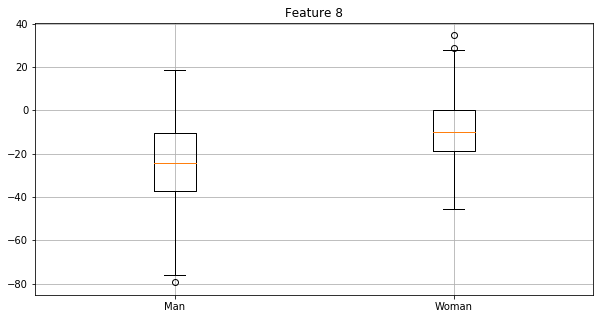

In [16]:
import statistics

def normalize_data(feature_set, n):
    '''
    feature_set has to be an array of length N_FEATURES
    every kth element of this array is the list containing the valeus of the kth feature of all fragments (aligned)
    n : number of points
    '''
    result = np.zeros((N_FEATURES, n))
    for f, values in enumerate(feature_set):
        sd = statistics.stdev(values)
        m = statistics.mean(values)
        normalized = np.random.normal(m, sd, n)
        result[f, :] = normalized
    return result

men_normalized = normalize_data(men_aligned, 200)
women_normalized = normalize_data(women_aligned, 200)

# plot some feature 
pl.figure(figsize=(10,5))
pl.boxplot([men_normalized[8], women_normalized[8]])
pl.title('Feature '+ str(8))
pl.xticks([1, 2], ['Man', 'Woman'])
pl.grid()

In [17]:
N_INITS = 10
N_TESTS = 10
K = 5
EPOCHS = 700
N_NEURONS = [2, 5, 10, 15, 20, 30, 35, 40]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [18]:
input_size = len(selected_features)
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
mf_dataset = create_dataset(men_normalized, women_normalized, selected_features)
print(mf_dataset.shape)

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([input_size,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((mf_dataset[:,0:input_size], mf_dataset[:,input_size:mf_dataset.shape[1]]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)
print('Tests done')

(400, 6)
Testing 2 neurons...
Testing 5 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 30 neurons...
Testing 35 neurons...
Testing 40 neurons...
Tests done


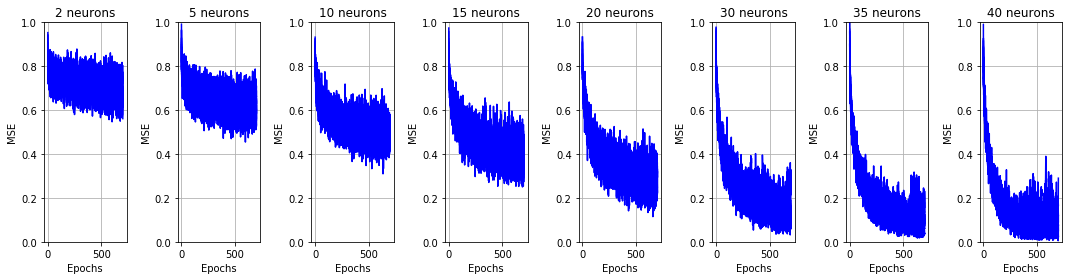

In [19]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In [20]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
mf_dataset = create_dataset(men_normalized, women_normalized, selected_features)
input_size = len(selected_features)

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([input_size,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                           # looping the tests
        nn.init_weights()                                                  # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
                                                            mf_dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,           # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
print('Tests done')

Testing 2 neurons...
Testing 5 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 30 neurons...
Testing 35 neurons...
Testing 40 neurons...
Tests done


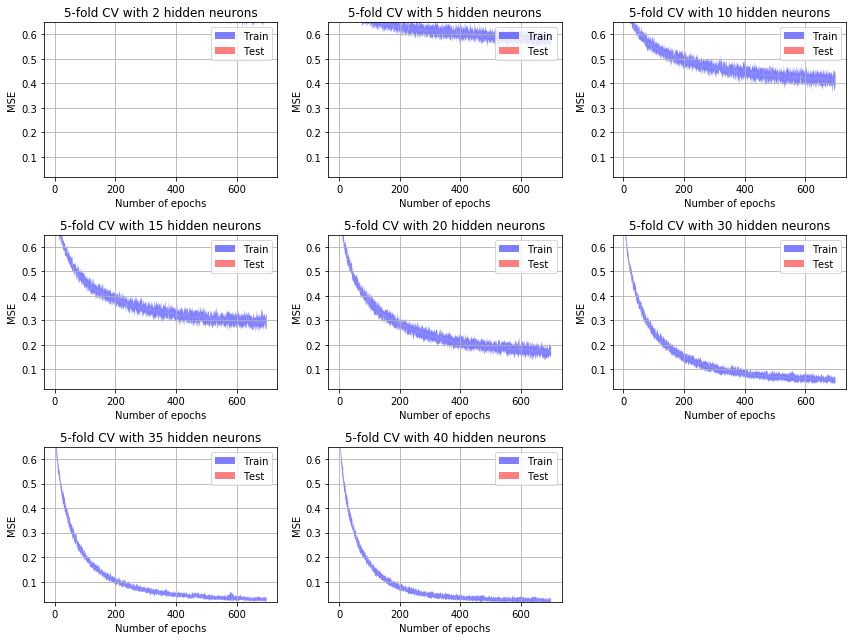

In [21]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()